Interaction Network
===============================================================

Now we will look at graph neural networks using the PyTorch Geometric library: <https://pytorch-geometric.readthedocs.io/>. See {cite:p}`PyTorchGeometric` for more details.

In [1]:
import torch
import torch_geometric
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from tqdm.notebook import tqdm
import numpy as np
local = False

In [2]:
import yaml

with open('definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

## Graph datasets
Here we have to define the graph dataset. We do this in a separate class following this example: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html#creating-larger-datasets

Formally, a graph is represented by a triplet $\mathcal G = (\mathbf{u}, V, E)$, consisting of a graph-level, or *global*, feature vector $\mathbf{u}$, a set of $N^v$ nodes $V$, and a set of $N^e$ edges $E$.
The nodes are given by $V = \{\mathbf{v}_i\}_{i=1:N^v}$, where $\mathbf{v}_i$ represents the $i$th node's attributes.
The edges connect pairs of nodes and are given by $E = \{\left(\mathbf{e}_k, r_k, s_k\right)\}_{k=1:N^e}$, where $\mathbf{e}_k$ represents the $k$th edge's attributes, and $r_k$ and $s_k$ are the indices of the "receiver" and 
"sender" nodes, respectively, connected by the $k$th edge (from the sender node to the receiver node).
The receiver and sender index vectors are an alternative way of encoding the directed adjacency matrix.

<img src="https://github.com/jmduarte/capstone-particle-physics-domain/raw/master/weeks/attributes.png" alt="attributes" width="500">

In [3]:
from GraphDataset import GraphDataset
if local:
    file_names = ['/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_10.root']
    file_names_test = ['/teams/DSC180A_FA20_A00/b06particlephysics/test/ntuple_merged_0.root']
else:
    file_names = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root']
    file_names_test = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root']

graph_dataset = GraphDataset('gdata_train', features, labels, spectators, n_events=8000, n_events_merge=1, 
                             file_names=file_names)

test_dataset = GraphDataset('gdata_test', features, labels, spectators, n_events=2000, n_events_merge=1, 
                             file_names=file_names_test)

## Graph neural network

Here, we recapitulate the "graph network" (GN) formalism {cite:p}`battaglia2018relational`, which generalizes various GNNs and other similar methods.
GNs are graph-to-graph mappings, whose output graphs have the same node and edge structure as the input. 
Formally, a GN block contains three "update" functions, $\phi$, and three "aggregation" functions, $\rho$.
The stages of processing in a single GN block are:

$
\begin{align}
    \mathbf{e}'_k &= \phi^e\left(\mathbf{e}_k, \mathbf{v}_{r_k}, \mathbf{v}_{s_k}, \mathbf{u} \right) & \mathbf{\bar{e}}'_i &= \rho^{e \rightarrow v}\left(E'_i\right) & \text{(Edge block),}\\
    \mathbf{v}'_i &= \phi^v\left(\mathbf{\bar{e}}'_i, \mathbf{v}_i, \mathbf{u}\right) & 
    \mathbf{\bar{e}}' &= \rho^{e \rightarrow u}\left(E'\right) &  \text{(Node block),}\\
    \mathbf{u}' &= \phi^u\left(\mathbf{\bar{e}}', \mathbf{\bar{v}}', \mathbf{u}\right) & 
    \mathbf{\bar{v}}' &= \rho^{v \rightarrow u}\left(V'\right) &\text{(Global block).}
  \label{eq:gn-functions}
\end{align}
$

where $E'_i = \left\{\left(\mathbf{e}'_k, r_k, s_k \right)\right\}_{r_k=i,\; k=1:N^e}$ contains the updated edge features for edges whose receiver node is the $i$th node, $E' = \bigcup_i E_i' = \left\{\left(\mathbf{e}'_k, r_k, s_k \right)\right\}_{k=1:N^e}$ is the set of updated edges, and $V'=\left\{\mathbf{v}'_i\right\}_{i=1:N^v}$ is the set of updated nodes.

<img src="https://github.com/jmduarte/capstone-particle-physics-domain/raw/master/weeks/GN-full-block.png" alt="GN full block" width="500">

We will define an interaction network model similar to Ref. {cite:p}`Moreno:2019neq`, but just modeling the particle-particle interactions. It will take as input all of the tracks (with 48 features) without truncating or zero-padding. Another modification is the use of batch normalization {cite:p}`bn` layers to improve the stability of the training.

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, global_mean_pool
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d
from torch_scatter import scatter_mean
from torch_geometric.nn import MetaLayer

inputs = 48
hidden = 128
outputs = 2

class EdgeBlock(torch.nn.Module):
    def __init__(self):
        super(EdgeBlock, self).__init__()
        self.edge_mlp = Seq(Lin(inputs*2, hidden), 
                            BatchNorm1d(hidden),
                            ReLU(),
                            Lin(hidden, hidden))

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest], 1)
        return self.edge_mlp(out)

class NodeBlock(torch.nn.Module):
    def __init__(self):
        super(NodeBlock, self).__init__()
        self.node_mlp_1 = Seq(Lin(inputs+hidden, hidden), 
                              BatchNorm1d(hidden),
                              ReLU(), 
                              Lin(hidden, hidden))
        self.node_mlp_2 = Seq(Lin(inputs+hidden, hidden), 
                              BatchNorm1d(hidden),
                              ReLU(), 
                              Lin(hidden, hidden))

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out)

    
class GlobalBlock(torch.nn.Module):
    def __init__(self):
        super(GlobalBlock, self).__init__()
        self.global_mlp = Seq(Lin(hidden, hidden),                               
                              BatchNorm1d(hidden),
                              ReLU(), 
                              Lin(hidden, outputs))

    def forward(self, x, edge_index, edge_attr, u, batch):
        out = scatter_mean(x, batch, dim=0)
        return self.global_mlp(out)


class InteractionNetwork(torch.nn.Module):
    def __init__(self):
        super(InteractionNetwork, self).__init__()
        self.interactionnetwork = MetaLayer(EdgeBlock(), NodeBlock(), GlobalBlock())
        self.bn = BatchNorm1d(inputs)
        
    def forward(self, x, edge_index, batch):
        
        x = self.bn(x)
        x, edge_attr, u = self.interactionnetwork(x, edge_index, None, None, batch)
        return u
    
model = InteractionNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)

## Define training loop

In [5]:
@torch.no_grad()
def test(model, loader, total, batch_size, leave=False):
    model.eval()
    
    xentropy = nn.CrossEntropyLoss(reduction='mean')

    sum_loss = 0.
    t = tqdm(enumerate(loader), total=total/batch_size, leave=leave)
    for i, data in t:
        data = data.to(device)
        y = torch.argmax(data.y, dim=1)
        batch_output = model(data.x, data.edge_index, data.batch)
        batch_loss_item = xentropy(batch_output, y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size, leave=False):
    model.train()
    
    xentropy = nn.CrossEntropyLoss(reduction='mean')

    sum_loss = 0.
    t = tqdm(enumerate(loader), total=total/batch_size, leave=leave)
    for i, data in t:
        data = data.to(device)
        y = torch.argmax(data.y, dim=1)
        optimizer.zero_grad()
        batch_output = model(data.x, data.edge_index, data.batch)
        batch_loss = xentropy(batch_output, y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

## Define training, validation, testing data generators

In [6]:
from torch_geometric.data import Data, DataListLoader, Batch
from torch.utils.data import random_split

def collate(items):
    l = sum(items, [])
    return Batch.from_data_list(l)

torch.manual_seed(0)
valid_frac = 0.20
full_length = len(graph_dataset)
valid_num = int(valid_frac*full_length)
batch_size = 32

train_dataset, valid_dataset = random_split(graph_dataset, [full_length-valid_num,valid_num])

train_loader = DataListLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
train_loader.collate_fn = collate
valid_loader = DataListLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
valid_loader.collate_fn = collate
test_loader = DataListLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader.collate_fn = collate


train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)
print(full_length)
print(train_samples)
print(valid_samples)
print(test_samples)

920
736
184
1889


/Users/drankin/miniconda3/envs/ml-iaifi/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataListLoader' is deprecated, use 'loader.DataListLoader' instead
  warnings.warn(out)


## Train

In [7]:
import os.path as osp

n_epochs = 10
stale_epochs = 0
best_valid_loss = 99999
patience = 5
t = tqdm(range(0, n_epochs))

for epoch in t:
    loss = train(model, optimizer, train_loader, train_samples, batch_size, leave=bool(epoch==n_epochs-1))
    valid_loss = test(model, valid_loader, valid_samples, batch_size, leave=bool(epoch==n_epochs-1))
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('           Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('interactionnetwork_best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 00, Training Loss:   0.3385
           Validation Loss: 1.9043
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 01, Training Loss:   0.2101
           Validation Loss: 0.2134
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 02, Training Loss:   0.1870
           Validation Loss: 0.1831
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 03, Training Loss:   0.1541
           Validation Loss: 0.2450
Stale epoch


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 04, Training Loss:   0.1819
           Validation Loss: 0.2112
Stale epoch


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 05, Training Loss:   0.1532
           Validation Loss: 0.1984
Stale epoch


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 06, Training Loss:   0.1305
           Validation Loss: 0.1826
New best model saved to: interactionnetwork_best.pth


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 07, Training Loss:   0.1173
           Validation Loss: 0.2347
Stale epoch


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 08, Training Loss:   0.0961
           Validation Loss: 0.1863
Stale epoch


  0%|          | 0/23.0 [00:00<?, ?it/s]

  0%|          | 0/5.75 [00:00<?, ?it/s]

Epoch: 09, Training Loss:   0.1469
           Validation Loss: 0.2200
Stale epoch


## Evaluate on testing data

In [8]:
model.eval()
t = tqdm(enumerate(test_loader),total=test_samples/batch_size)
y_test = []
y_predict = []
for i,data in t:
    data = data.to(device)    
    batch_output = model(data.x, data.edge_index, data.batch)    
    y_predict.append(batch_output.detach().cpu().numpy())
    y_test.append(data.y.cpu().numpy())
y_test = np.concatenate(y_test)
y_predict = np.concatenate(y_predict)

  0%|          | 0/59.03125 [00:00<?, ?it/s]

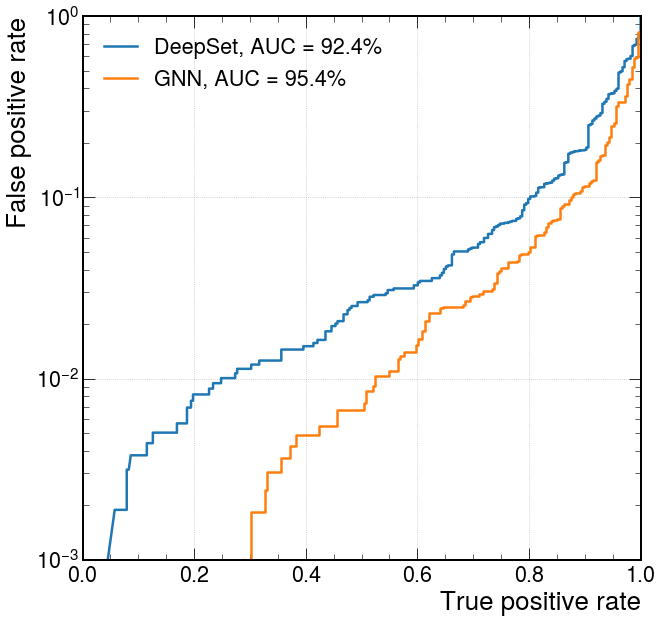

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)
# create ROC curves
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test[:,1], y_predict[:,1])
with open('gnn_roc.npy', 'wb') as f:
    np.save(f, fpr_gnn)
    np.save(f, tpr_gnn)
    np.save(f, threshold_gnn)

with open('deepset_roc.npy', 'rb') as f:
    fpr_deepset = np.load(f)
    tpr_deepset = np.load(f)
    threshold_deepset = np.load(f)
    
# plot ROC curves
plt.figure()
plt.plot(tpr_deepset, fpr_deepset, lw=2.5, label="DeepSet, AUC = {:.1f}%".format(auc(fpr_deepset,tpr_deepset)*100))
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GNN, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()